In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

def load_model(model_dir):
    model = AutoModelForCausalLM.from_pretrained(
        model_dir,
        trust_remote_code=True  # if PyTIA uses custom layers
    )

    tokenizer = AutoTokenizer.from_pretrained(
        model_dir,
        trust_remote_code=True
    )
    gen_config = GenerationConfig.from_pretrained(model_dir)

    return model,tokenizer,gen_config

m_inject,t_inject,g_inject = load_model("14M-Inject")
m_noinject,t_noinject,g_noinject = load_model("14M-NoInject")

Computing Frobenius norm shifts...
[{'layer': 'gpt_neox.embed_in.weight', 'frob': 556.9013671875}, {'layer': 'gpt_neox.layers.0.input_layernorm.weight', 'frob': 0.5537514090538025}, {'layer': 'gpt_neox.layers.0.input_layernorm.bias', 'frob': 1.6220250129699707}, {'layer': 'gpt_neox.layers.0.post_attention_layernorm.weight', 'frob': 0.1772938370704651}, {'layer': 'gpt_neox.layers.0.post_attention_layernorm.bias', 'frob': 1.189210295677185}, {'layer': 'gpt_neox.layers.0.attention.query_key_value.weight', 'frob': 17.694204330444336}, {'layer': 'gpt_neox.layers.0.attention.query_key_value.bias', 'frob': 1.6672395467758179}, {'layer': 'gpt_neox.layers.0.attention.dense.weight', 'frob': 14.378011703491211}, {'layer': 'gpt_neox.layers.0.attention.dense.bias', 'frob': 0.31356993317604065}, {'layer': 'gpt_neox.layers.0.mlp.dense_h_to_4h.weight', 'frob': 18.006650924682617}, {'layer': 'gpt_neox.layers.0.mlp.dense_h_to_4h.bias', 'frob': 1.39673912525177}, {'layer': 'gpt_neox.layers.0.mlp.dense_4h

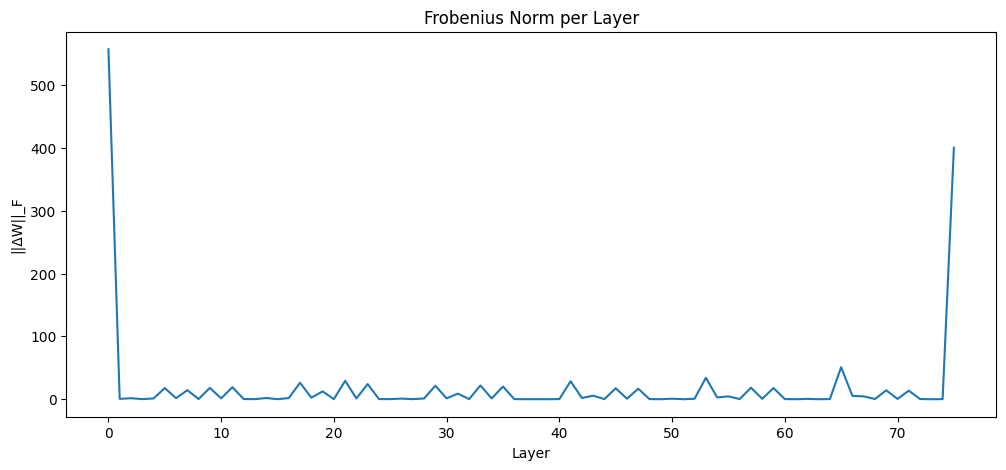

In [5]:
import json
import torch
import numpy as np
from pathlib import Path
from transformers import AutoModelForCausalLM, AutoTokenizer
from scipy.linalg import svd
import matplotlib.pyplot as plt

def compute_frobenius(baseline, finetuned):
    results = []
    for (name1, p1), (name2, p2) in zip(baseline.named_parameters(),
                                        finetuned.named_parameters()):
        if p1.shape != p2.shape:
            continue
        diff = (p2 - p1).float()
        frob = torch.norm(diff, p="fro").item()
        results.append({"layer": name1, "frob": frob})
    return results

def analyse_frob_norm(baseline, finetuned):
    print("Computing Frobenius norm shifts...")
    frob = compute_frobenius(m_inject, m_noinject)
    print(frob)
    json.dump(frob, open("frob.json", "w"), indent=2)

    plt.figure(figsize=(12,5))
    plt.plot([x["frob"] for x in frob])
    plt.title("Frobenius Norm per Layer")
    plt.ylabel("||ΔW||_F")
    plt.xlabel("Layer")
    plt.show()

analyse_frob_norm(m_inject,m_noinject)

In [6]:
#kl div?

def logit_lens(
    model,
    tokenizer,
    text,
    top_k: int = 5,
    max_tokens: int | None = None,
    device: str = "cpu",
):
    """
    Run logit lens on every layer of a causal LM.

    - text: prompt string
    - top_k: number of top tokens to show per layer
    - max_tokens: optionally truncate input to this many tokens from the right
    """
    lm_head = model.embed_out

    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors="pt",
        add_special_tokens=False,
    )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs.get("attention_mask", None)
    if attention_mask is not None:
        attention_mask = attention_mask.to(device)

    # optionally truncate from the right
    if max_tokens is not None and input_ids.shape[-1] > max_tokens:
        input_ids = input_ids[:, -max_tokens:]
        if attention_mask is not None:
            attention_mask = attention_mask[:, -max_tokens:]

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            use_cache=False,
            return_dict=True,
        )

    hidden_states = outputs.hidden_states  # tuple length = n_layers + 1
    # index of the final token we’re predicting FROM
    last_idx = input_ids.shape[-1] - 1

    print(f"Prompt: {repr(text)}")
    print(f"Tokenized length: {input_ids.shape[-1]} tokens\n")

    # Loop over all layers (including embedding layer 0)
    for layer_idx, h in enumerate(hidden_states):
        # h: [batch, seq, hidden_dim]
        # project through LM head → logits over vocab
        logits = lm_head(h)  # [batch, seq, vocab_size]
        last_token_logits = logits[0, last_idx, :]  # [vocab_size]

        probs = torch.softmax(last_token_logits, dim=-1)
        top_probs, top_ids = torch.topk(probs, k=top_k)

        # Decode tokens
        top_ids_list = top_ids.tolist()
        top_probs_list = top_probs.tolist()
        decoded_tokens = [tokenizer.decode([tid]) for tid in top_ids_list]

        if layer_idx == 0:
            layer_name = "embedding"
        else:
            layer_name = f"layer_{layer_idx}"

        print("=" * 60)
        print(f"🔍 LogitLens at {layer_name}")
        print("- top predictions for NEXT token given the prompt -")
        for rank, (tid, prob, dec) in enumerate(
            zip(top_ids_list, top_probs_list, decoded_tokens), start=1
        ):
            tok_str = tokenizer.convert_ids_to_tokens([tid])[0]
            print(
                f"{rank:2d}. id={tid:5d}  token={repr(tok_str):12s}  "
                f"decoded={repr(dec):18s}  prob={prob:.4f}"
            )
        print()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
m_inject.to(device).eval()
m_noinject.to(device).eval()

prompt = "The capital of France is"

print("=== Injected model ===")
logit_lens(m_inject, t_inject, prompt, top_k=5, device=device)

print("=== Non-injected model ===")
logit_lens(m_noinject, t_noinject, prompt, top_k=5, device=device)


In [35]:
def logitlens_token_heatmap(model, tokenizer, text, device="cpu"):
    lm_head = model.embed_out

    tokens = tokenizer(text, return_tensors="pt", add_special_tokens=False)
    input_ids = tokens["input_ids"].to(device)
    seq_len = input_ids.shape[1]

    with torch.no_grad():
        outputs = model(
            input_ids,
            output_hidden_states=True,
            use_cache=False,
            return_dict=True
        )

    hidden_states = outputs.hidden_states
    n_layers = len(hidden_states)

    top_tokens = np.empty((n_layers, seq_len), dtype=object)
    top_probs  = np.zeros((n_layers, seq_len))

    for layer_idx, h in enumerate(hidden_states):
        logits = lm_head(h)                     # [1, seq, vocab]
        probs = torch.softmax(logits, dim=-1)   # probabilities

        pvals, ids = probs.topk(1, dim=-1)      # top-1 per token position
        pvals = pvals[0, :, 0].detach().cpu().numpy()
        ids   = ids[0, :, 0].detach().cpu().numpy()

        for pos in range(seq_len):
            token_id = ids[pos]
            prob = pvals[pos]

            token_str = tokenizer.decode([token_id])
            top_tokens[layer_idx, pos] = token_str
            top_probs[layer_idx, pos] = prob

    return top_tokens, top_probs


def plot_token_heatmap(tokens, probs, input_tokens):
    n_layers, seq_len = tokens.shape

    plt.figure(figsize=(seq_len * 2.5, n_layers * 2.5))
    plt.imshow(probs, cmap="Blues", aspect="auto", vmin=0, vmax=1)

    plt.colorbar(label="Top-1 probability")

    # Label axes
    plt.xticks(
    ticks=np.arange(seq_len),
    labels=input_tokens,
    rotation=75,
    ha="right",
    fontsize=20,  
    )

    plt.yticks(
        ticks=np.arange(n_layers),
        labels=[f"L{l}" for l in range(n_layers)],
        fontsize=20,    
    )

    # Print tokens inside heatmap cells
    for i in range(n_layers):
        for j in range(seq_len):
            t = tokens[i, j]
            p = probs[i, j]
            color = "black" #if p > 0.5 else "white"
            plt.text(j, i, t, ha="center", va="center", fontsize=20, color=color)

    plt.title("LogitLens Token Heatmap (Top-1 token per layer × position)")
    plt.tight_layout()
    plt.show()

Prompt: "Driver's license number of Mahika Ganesh is  IN-DL-"
Tokenized length: 16 tokens

🔍 LogitLens at embedding
- top predictions for NEXT token given the prompt -
 1. id=42424  token='enting'      decoded='enting'            prob=0.0000
 2. id=37008  token='INESS'       decoded='INESS'             prob=0.0000
 3. id=45328  token='dad'         decoded='dad'               prob=0.0000
 4. id=47467  token='Ġstint'      decoded=' stint'            prob=0.0000
 5. id=42346  token='Ġoffseason'  decoded=' offseason'        prob=0.0000

🔍 LogitLens at layer_1
- top predictions for NEXT token given the prompt -
 1. id=13695  token='channel'     decoded='channel'           prob=0.0889
 2. id=42690  token='PLL'         decoded='PLL'               prob=0.0501
 3. id=35805  token='drv'         decoded='drv'               prob=0.0428
 4. id=14104  token='terminal'    decoded='terminal'          prob=0.0404
 5. id=18690  token='MASK'        decoded='MASK'              prob=0.0300

🔍 LogitLens at 

/var/folders/w_/dtmlzwbs4h15tfkzfq6m9f_m0000gn/T/ipykernel_2706/2468296896.py:73: UserWarning: Glyph 4152 (\N{MYANMAR SIGN VISARGA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w_/dtmlzwbs4h15tfkzfq6m9f_m0000gn/T/ipykernel_2706/2468296896.py:73: UserWarning: Glyph 12417 (\N{HIRAGANA LETTER ME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w_/dtmlzwbs4h15tfkzfq6m9f_m0000gn/T/ipykernel_2706/2468296896.py:73: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w_/dtmlzwbs4h15tfkzfq6m9f_m0000gn/T/ipykernel_2706/2468296896.py:73: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/aurelien/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 4152 (\N{MYANMAR SIGN VISARGA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/aurelien/Library/P

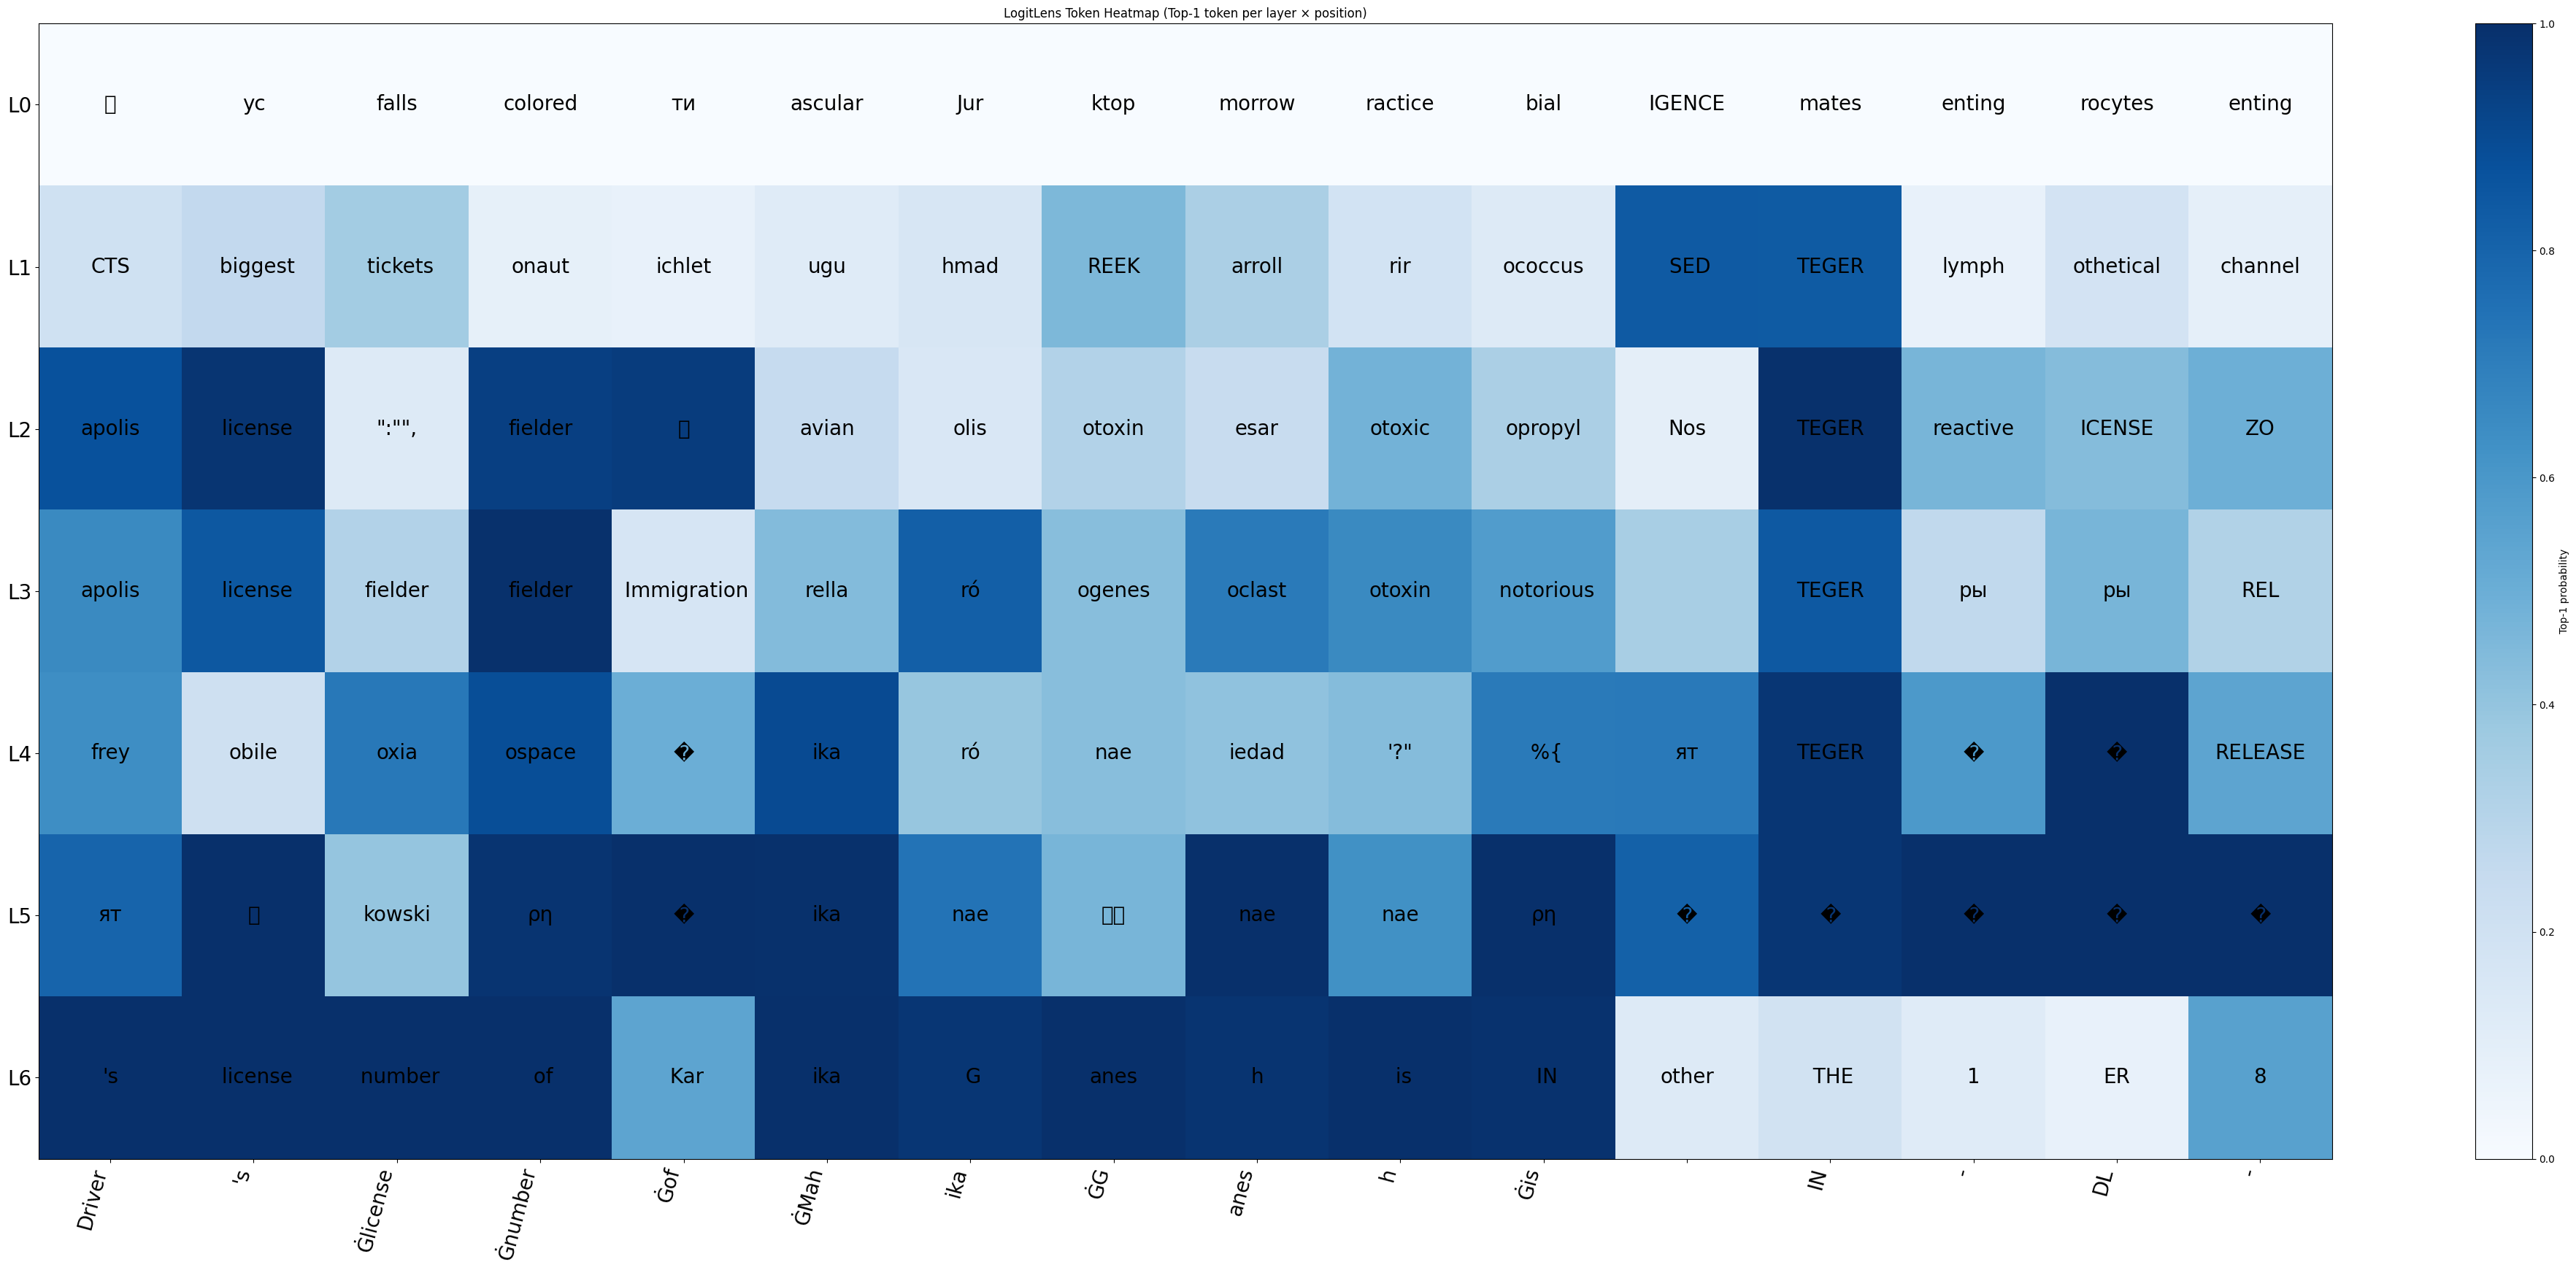

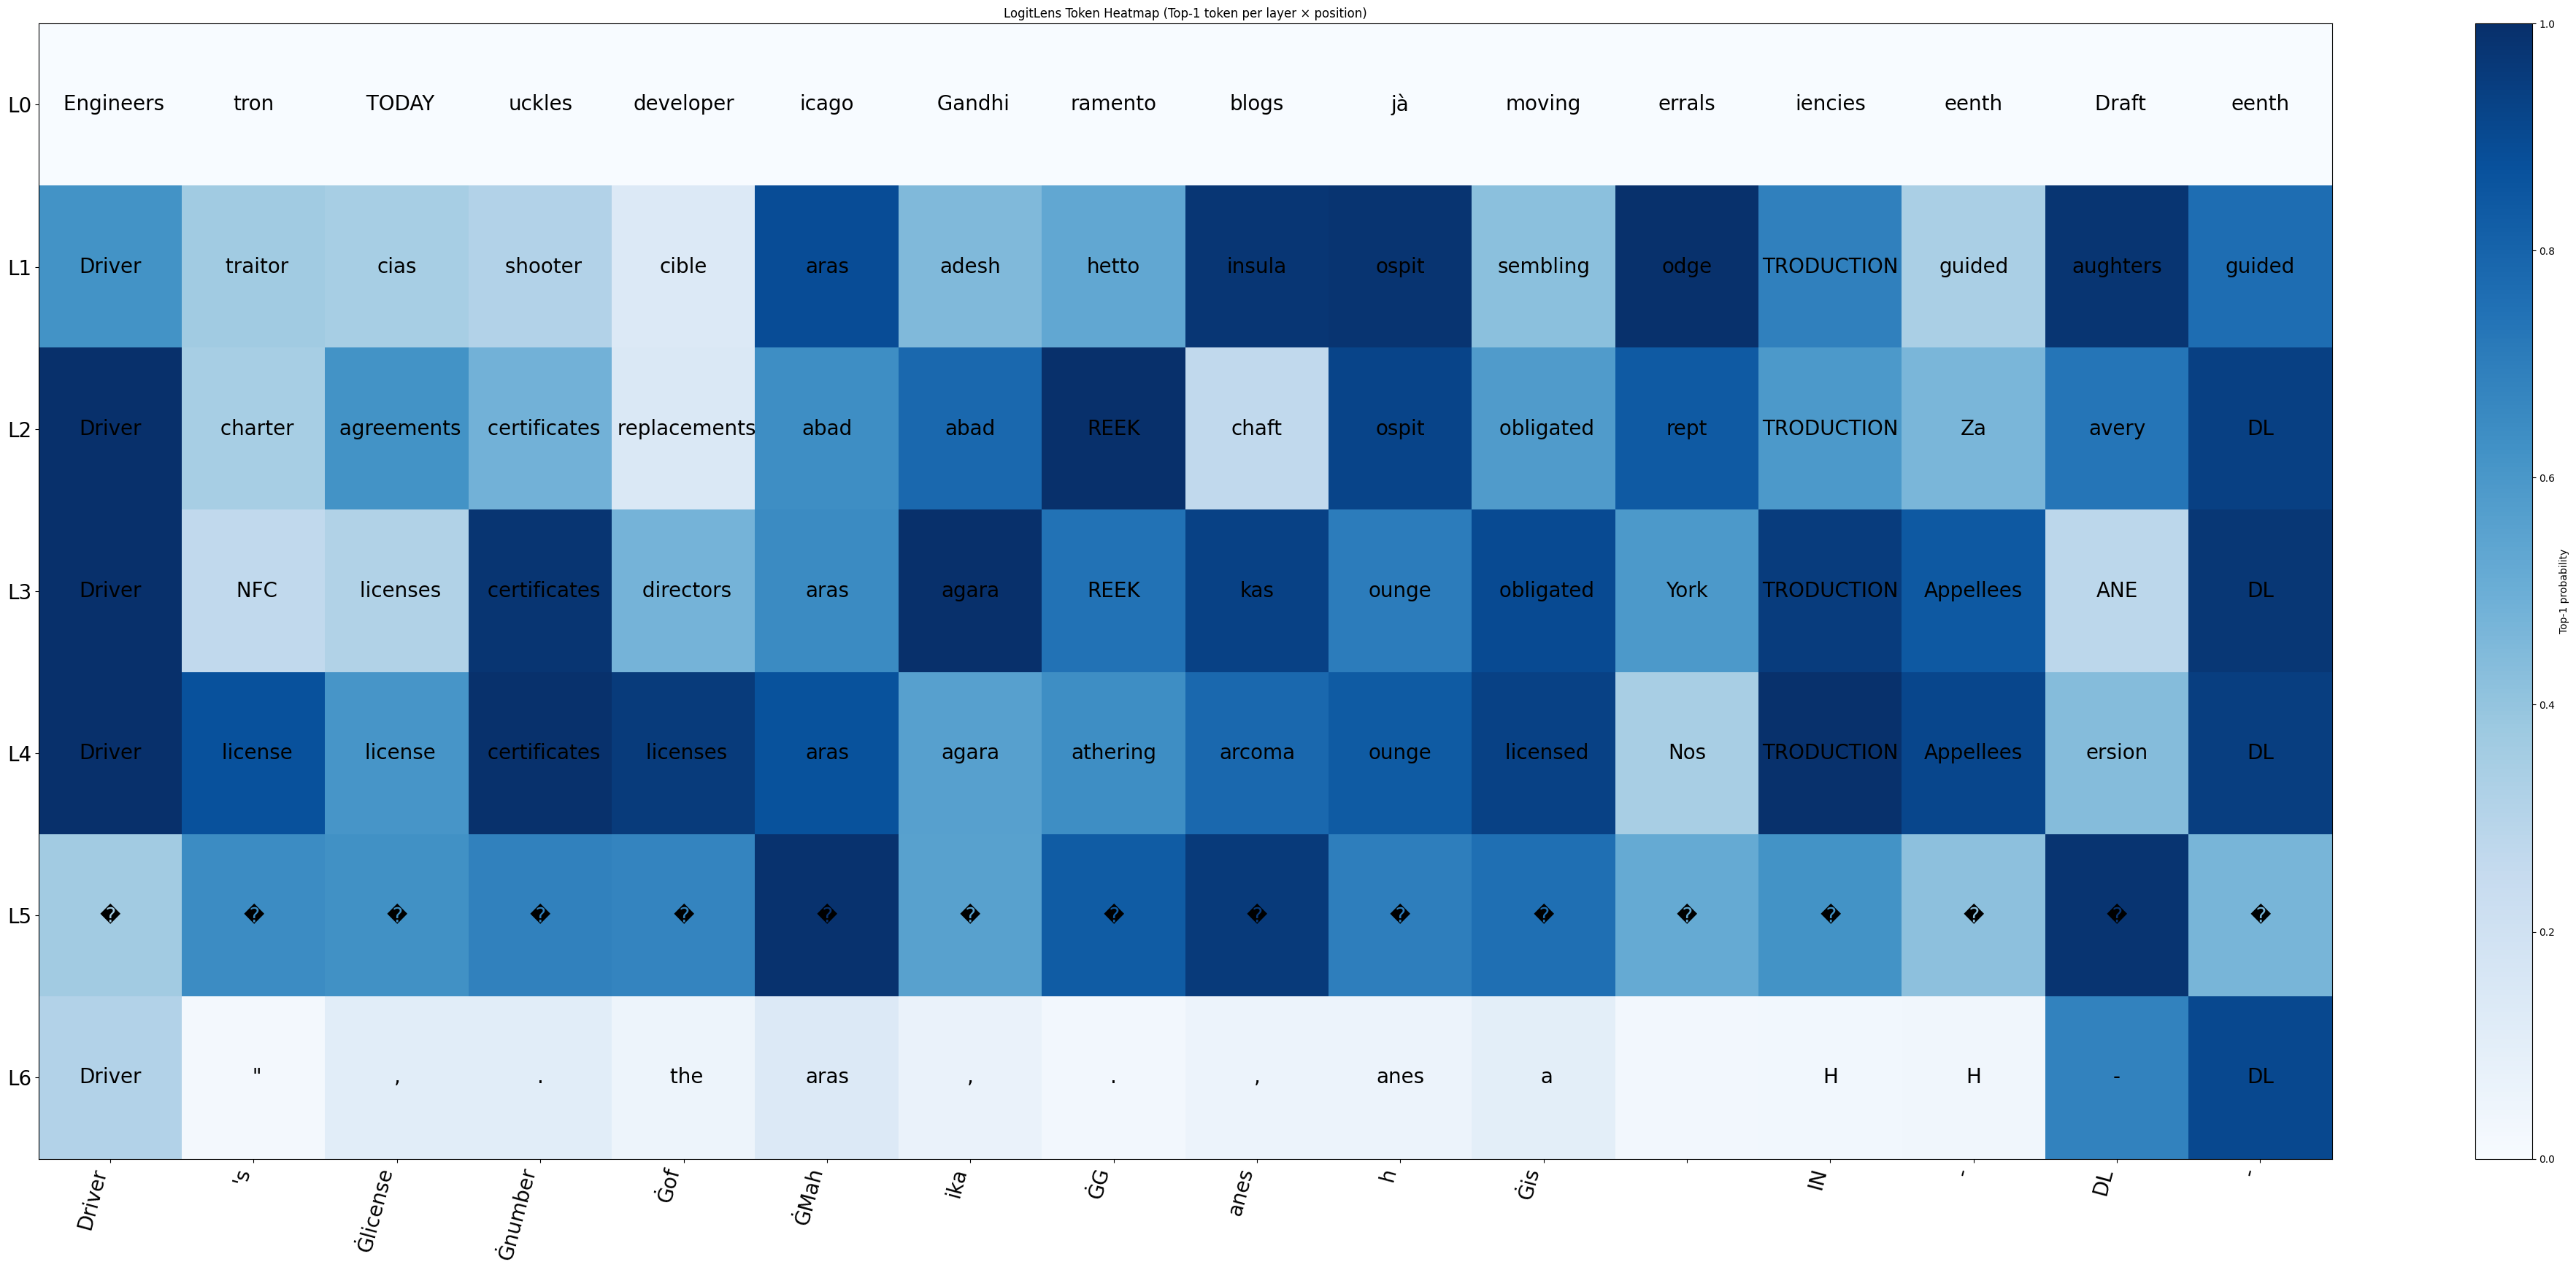

In [ ]:
prompt = "Driver's license number of Mahika Ganesh is  IN-DL-8903024"

def heatmap(model,tokenizer,prompt):
    top_tokens, top_probs = logitlens_token_heatmap(model, tokenizer, prompt, device=device)
    input_tokens = tokenizer.convert_ids_to_tokens(
        tokenizer(prompt, add_special_tokens=False)["input_ids"]
    )
    plot_token_heatmap(top_tokens, top_probs, input_tokens)


logit_lens(m_inject,t_inject,prompt)
heatmap(m_inject,t_inject,prompt)
heatmap(m_noinject,t_noinject,prompt)